## 1. Minimalize LSTM

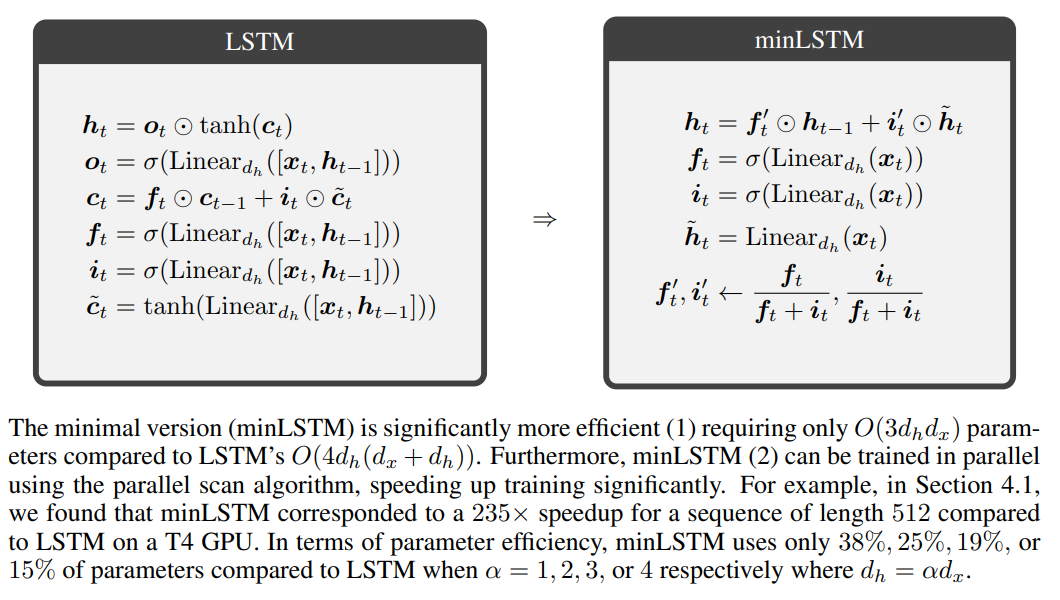

### 1.1 LSTM cell

LSTM은 RNN의 장기 기억 능력을 개선하기 위해 개발되었으며,  
다음의 `4가지 gate를 통해 정보를 선택적으로 유지하거나 제거`

- Forget gate ($f_t$): 잊어야 할 정보를 결정
- Input gate ($i_t$): 새로 추가할 정보를 결정
- Candidate memory cell ($\tilde{c}_t$): 새로 들어오는 정보를 저장하는 후보
- Output gate ($o_t$): 현재 히든 상태로 출력할 정보를 결정

이를 기반으로 하는 수식은 다음과 같음

$
\begin{aligned}
f_t &= \sigma(W_f [x_t, h_{t-1}] + b_f) \\[5pt]
i_t &= \sigma(W_i [x_t, h_{t-1}] + b_i) \\[5pt]
\tilde{c}_t &= \tanh(W_c [x_t, h_{t-1}] + b_c) \\[5pt]
o_t &= \sigma(W_o [x_t, h_{t-1}] + b_o) \\[5pt]
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\[5pt]
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$


- $\sigma$ : sigmoid 함수
- $\odot$ : 요소별 곱셈(element-wise multiplication)

이를 기반으로 구현한 코드는 다음과 같음

In [1]:
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        # 게이트 계산: 입력-은닉 가중치 합
        gates = self.linear_ih(x_t) + self.linear_hh(h_prev)

        # i, f, g, o 게이트 분할
        i_t, f_t, g_t, o_t = torch.chunk(gates, 4, dim=1)

        # 활성화
        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        g_t = torch.tanh(g_t)
        o_t = torch.sigmoid(o_t)

        # 셀 상태와 은닉 상태 업데이트
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, x, h0, c0):
        batch_size, seq_len, _ = x.size()
        h, c = h0, c0
        outputs = []

        for t in range(seq_len):
            h, c = self.cell(x[:, t, :], h, c)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), (h, c)

In [4]:
torch.manual_seed(42)
device = torch.device('cpu') # 'cuda'로 적용할 경우, torch 내부의 fused kernel을 사용하여 결과값의 차이가 커질 수 있음

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)
c0 = torch.randn(batch_size, hidden_size).to(device)

my_lstm = LSTM(input_size, hidden_size).to(device)
torch_lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)

with torch.no_grad():
    torch_lstm.weight_ih_l0.copy_(my_lstm.cell.linear_ih.weight)
    torch_lstm.bias_ih_l0.copy_(my_lstm.cell.linear_ih.bias)
    torch_lstm.weight_hh_l0.copy_(my_lstm.cell.linear_hh.weight)
    torch_lstm.bias_hh_l0.copy_(my_lstm.cell.linear_hh.bias)

out_my, (h_n_my, c_n_my) = my_lstm(x, h0, c0)
out_torch, (h_n_torch, c_n_torch) = torch_lstm(x, (h0.unsqueeze(0), c0.unsqueeze(0)))

print("CPU LSTM Output 차이:", torch.abs(out_my - out_torch).max().item())
print("CPU LSTM hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())
print("CPU LSTM cell 차이:", torch.abs(c_n_my - c_n_torch.squeeze(0)).max().item())

CPU LSTM Output 차이: 5.960464477539063e-08
CPU LSTM hidden 차이: 2.9802322387695312e-08
CPU LSTM cell 차이: 1.1920928955078125e-07


### 1.2 Minimalizing Step 1
- 출력 게이트 제거

In [ ]:
class MinLSTMCell_Step1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # 이제 3 * hidden_size만 필요
        self.linear_ih = nn.Linear(input_size, 3 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 3 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        gates = self.linear_ih(x_t) + self.linear_hh(h_prev)
        i_t, f_t, g_t = torch.chunk(gates, 3, dim=1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        g_t = torch.tanh(g_t)

        c_t = f_t * c_prev + i_t * g_t
        h_t = torch.tanh(c_t)  # 출력 게이트 제거

        return h_t, c_t

### 1.3 Minimalizing Step 2
- 이전 은닉 상태 의존성 $h_{t-1}$ 제거

In [4]:
class MinLSTMCell_Step2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # linear_hh 제거, linear_ih는 3 * hidden_size 유지
        self.linear_ih = nn.Linear(input_size, 3 * hidden_size)

    def forward(self, x_t, c_prev):
        gates = self.linear_ih(x_t)  # h_prev 의존성 제거
        i_t, f_t, g_t = torch.chunk(gates, 3, dim=1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        g_t = torch.tanh(g_t)

        c_t = f_t * c_prev + i_t * g_t
        h_t = torch.tanh(c_t)

        return h_t, c_t

### Minimalizing Step 3
- Input Gate와 Forget Gate 통합

In [ ]:
class MinLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_ih = nn.Linear(input_size, 3 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        gates = self.linear_ih(x_t)
        i_raw, f_raw, g_t = torch.chunk(gates, 3, dim=1)

        i_t = torch.sigmoid(i_raw)
        f_t = torch.sigmoid(f_raw)
        sum_gates = f_t + i_t + 1e-10
        f_prime = f_t / sum_gates
        i_prime = i_t / sum_gates

        c_t = f_prime * c_prev + i_prime * g_t
        h_t = torch.tanh(c_t)

        return h_t, c_t

## 2. Minimalize GRU

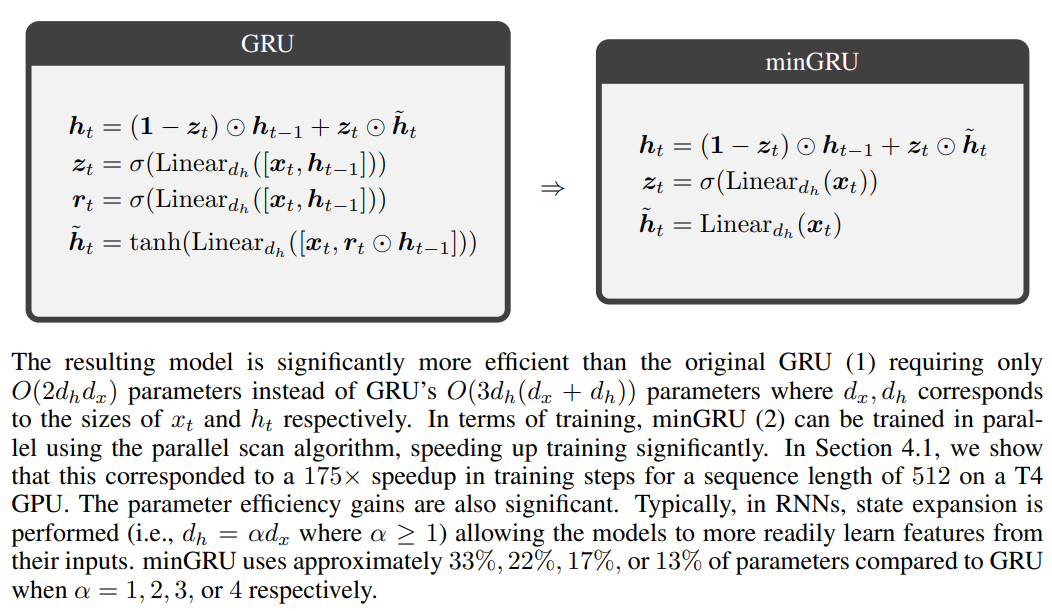

### 2.1 GRU Cell

GRU는 LSTM보다 구조가 간단하면서도 유사한 성능을 내며, 다음과 같은 두 개의 gate로 구성

- Update gate ($z_t$): 이전 상태를 얼마나 유지할지 결정
- Reset gate ($r_t$): 이전 상태를 얼마나 잊을지 결정

이를 이용한 수식은 다음과 같음

$
\begin{aligned}
z_t &= \sigma(W_z [x_t, h_{t-1}] + b_z) \\[5pt]
r_t &= \sigma(W_r [x_t, h_{t-1}] + b_r) \\[5pt]
\tilde{h}_t &= \tanh(W_h [x_t, r_t \odot h_{t-1}] + b_h) \\[5pt]
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$


위 수식에서,
- $x_t$: 시간 단계 $t$의 입력 벡터
- $h_t$: 시간 단계 $t$의 hidden state 벡터
- $z_t$: update gate (과거 정보를 유지할지 결정)
- $r_t$: reset gate (과거 정보를 잊을지 결정)
- $\sigma$: sigmoid 활성화 함수
- $\odot$: element-wise 곱셈 연산
- $W$, $U$: 학습 가능한 가중치
- $b$: 편향(bias)

이를 이용해 코드로 구현하면 다음과 같음

In [8]:
import torch
import torch.nn as nn

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 입력 → 게이트 연산 (reset, update, new)
        self.linear_ih = nn.Linear(input_size, 3 * hidden_size)
        # 은닉 → 게이트 연산
        self.linear_hh = nn.Linear(hidden_size, 3 * hidden_size)

    def forward(self, x_t, h_prev):
        # 입력과 은닉에 대한 선형 변환
        gates_ih = self.linear_ih(x_t)     # (batch, 3*hidden)
        gates_hh = self.linear_hh(h_prev)  # (batch, 3*hidden)

        # 세 부분으로 분할: reset(r), update(z), new(n)
        i_r, i_z, i_n = gates_ih.chunk(3, dim=1)
        h_r, h_z, h_n = gates_hh.chunk(3, dim=1)

        # 게이트 활성화
        r_t = torch.sigmoid(i_r + h_r)
        z_t = torch.sigmoid(i_z + h_z)

        # 새 은닉 상태 후보
        n_t = torch.tanh(i_n + r_t * h_n)

        # 최종 은닉 상태 계산
        h_t = (1 - z_t) * n_t + z_t * h_prev
        return h_t

In [9]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.cell = GRUCell(input_size, hidden_size)

    def forward(self, x, h0):
        batch_size, seq_len, _ = x.size()
        h = h0
        outputs = []

        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs, h

In [12]:
torch.manual_seed(42)
device = torch.device('cpu')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)

my_gru = GRU(input_size, hidden_size).to(device)
torch_gru = nn.GRU(input_size, hidden_size, batch_first=True).to(device)

# 가중치 복사
with torch.no_grad():
    torch_gru.weight_ih_l0.copy_(my_gru.cell.linear_ih.weight)
    torch_gru.bias_ih_l0.copy_(my_gru.cell.linear_ih.bias)
    torch_gru.weight_hh_l0.copy_(my_gru.cell.linear_hh.weight)
    torch_gru.bias_hh_l0.copy_(my_gru.cell.linear_hh.bias)
    
out_my, h_n_my = my_gru(x, h0)
out_torch, h_n_torch = torch_gru(x, h0.unsqueeze(0))

print("GRU 전체 Output 차이:", torch.abs(out_my - out_torch).max().item())
print("GRU 마지막 hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())

GRU 전체 Output 차이: 1.1920928955078125e-07
GRU 마지막 hidden 차이: 1.210719347000122e-08


### 2.2 Minimalizing Step 1

- 리셋 게이트 r_t 제거 및 관련 파라미터 축소
- 새 은닉 상태 계산은 linear_ih의 마지막 부분(i_n) 만 사용

In [13]:
class MinGRUCell_Step1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # update 게이트와 new candidate만 계산 (reset 제거)
        self.linear_ih = nn.Linear(input_size, 2 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 2 * hidden_size)

    def forward(self, x_t, h_prev):
        gi, gh = self.linear_ih(x_t), self.linear_hh(h_prev)
        i_z, i_n = gi.chunk(2, dim=1)
        h_z, h_n = gh.chunk(2, dim=1)

        z_t = torch.sigmoid(i_z + h_z)
        # reset 게이트 연산 제거
        n_t = torch.tanh(i_n + h_n)

        h_t = (1 - z_t) * n_t + z_t * h_prev
        return h_t

### 2.3 Minimalizing Step 2
- 은닉 입력(linear_hh) 의존성 제거
- 모든 연산을 오직 x_t 입력만으로 처리

In [ ]:
class MinGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # update gate 및 new candidate: 입력만으로 계산
        self.linear_ih = nn.Linear(input_size, 2 * hidden_size)

    def forward(self, x_t, h_prev):
        gi = self.linear_ih(x_t)
        i_z, i_n = gi.chunk(2, dim=1)

        z_t = torch.sigmoid(i_z)
        n_t = torch.tanh(i_n)

        h_t = (1 - z_t) * n_t + z_t * h_prev
        return h_t